In [12]:
# Import Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
# Load Dataset
data = pd.read_csv('Rotkehlchen_Data.csv')

# Initial Exploration
print("Dataset Head:")
print(data.head())

Dataset Head:
    timestamp  temp_Oie   p_Oie  ppn_Oie  ws_Oie  wd_Oie  temp_DE1   p_DE1  \
0  1999-01-01      -1.0  1011.3      0.0     2.8   133.0      -1.6  1013.1   
1  1999-01-02       0.6  1006.4      0.0     3.9   161.0       2.1  1005.5   
2  1999-01-03       1.9  1002.9      0.0     4.0   179.0       3.3  1002.6   
3  1999-01-04       4.5  1003.1      3.2     5.2   201.0       7.0  1003.4   
4  1999-01-05       7.8  1007.3     11.3     5.6   238.0       9.9  1008.4   

   ppn_DE1  cc_DE1  ...  year  spring  month_sin  month_cos   day_sin  \
0      0.0     4.7  ...  1999       1        0.5   0.866025  0.201299   
1      0.1     5.7  ...  1999       1        0.5   0.866025  0.394356   
2      0.0     5.7  ...  1999       1        0.5   0.866025  0.571268   
3      1.3     8.0  ...  1999       1        0.5   0.866025  0.724793   
4      2.5     7.7  ...  1999       1        0.5   0.866025  0.848644   

    day_cos  day_of_year_sin  day_of_year_cos  ringing_season  count  
0  0.97

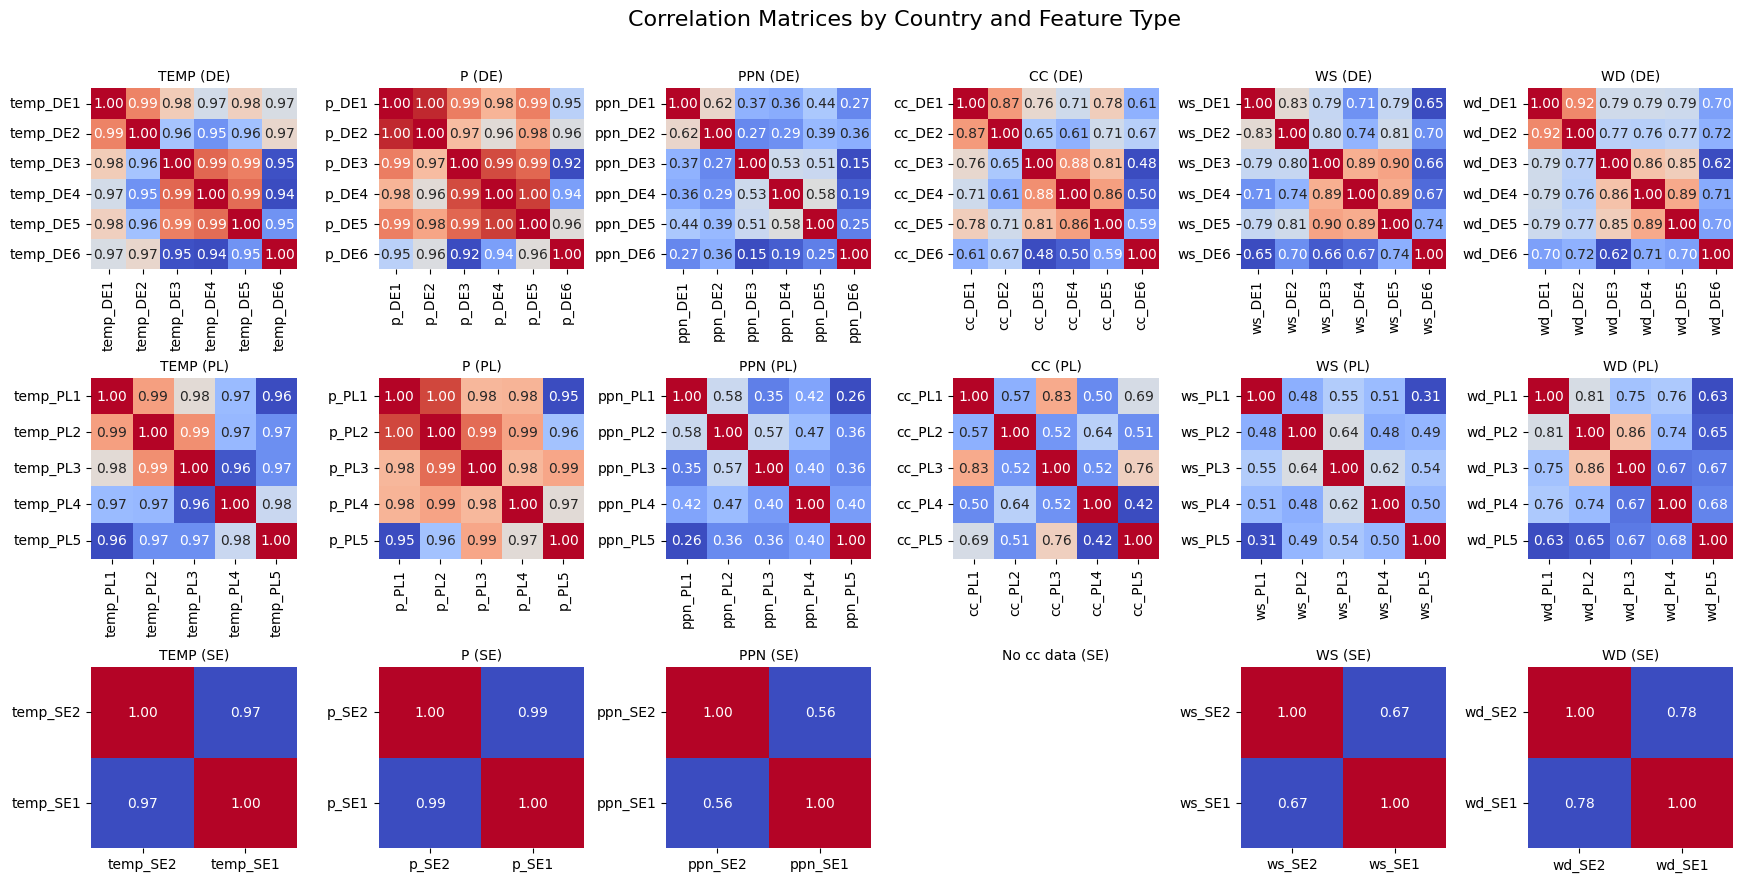

In [14]:
# Define countries and their respective stations
country_stations = {
    'DE': [col for col in data.columns if col.startswith('temp_DE') or col.startswith('p_DE') or col.startswith('ppn_DE') or col.startswith('cc_DE') or col.startswith('ws_DE') or col.startswith('wd_DE')],
    'PL': [col for col in data.columns if col.startswith('temp_PL') or col.startswith('p_PL') or col.startswith('ppn_PL') or col.startswith('cc_PL') or col.startswith('ws_PL') or col.startswith('wd_PL')],
    'DK': [col for col in data.columns if col.startswith('temp_DK') or col.startswith('p_DK') or col.startswith('ppn_DK') or col.startswith('cc_DK') or col.startswith('ws_DK') or col.startswith('wd_DK')],
    'SE': [col for col in data.columns if col.startswith('temp_SE') or col.startswith('p_SE') or col.startswith('ppn_SE') or col.startswith('cc_SE') or col.startswith('ws_SE') or col.startswith('wd_SE')],
    'LV': [col for col in data.columns if col.startswith('temp_LV') or col.startswith('p_LV') or col.startswith('ppn_LV') or col.startswith('cc_LV') or col.startswith('ws_LV') or col.startswith('wd_LV')]
}

# Function to calculate and plot the correlation matrix for a country's feature
def analyze_country_redundancy(data, country_code, feature_type, ax):
    # Match the exact feature prefix (e.g., "temp_", "p_", "ppn_")
    features = [col for col in country_stations[country_code] if col.startswith(f"{feature_type}_")]
    if len(features) > 1:
        corr_matrix = data[features].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=ax, cbar=False)
        ax.set_title(f"{feature_type.upper()} ({country_code})", fontsize=10)
        ax.tick_params(axis='y', rotation=0)  # Ensure horizontal y-axis labels
    else:
        ax.axis('off')  # Hide empty plots if insufficient features
        ax.set_title(f"No {feature_type} data ({country_code})", fontsize=10)

# Number of features per row
features_per_row = 6
feature_types = ['temp', 'p', 'ppn', 'cc', 'ws', 'wd']

# Create subplots
num_rows = len(country_stations) - 2  # Exclude LV and DK
fig, axes = plt.subplots(num_rows, features_per_row, figsize=(18, num_rows * 3))  # Adjust height per row to 2.5
fig.tight_layout(pad=4)  # Reduce padding to avoid excessive spacing

row_idx = 0  # Initialize row index for the subplot
for country in country_stations.keys():
    if country in ['LV', 'DK']:  # Exclude specific countries
        continue
    for col_idx, feature_type in enumerate(feature_types):
        ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
        analyze_country_redundancy(data, country, feature_type, ax)
    row_idx += 1  # Increment row index only for included countries

plt.subplots_adjust(hspace=0.6, wspace=0.4)  # Add vertical and horizontal spacing
plt.suptitle("Correlation Matrices by Country and Feature Type", fontsize=16, y=1.02)
plt.show()


In [15]:
# Cut columns
columns_to_keep = [
    "timestamp", 
    "temp_Oie", "p_Oie", "ppn_Oie",           "ws_Oie", "wd_Oie",
    "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
    "temp_PL1", "p_PL1", "ppn_PL1", "cc_PL1", "ws_PL1", "wd_PL1",
    "temp_DK",  "p_DK",                       "ws_DK",  "wd_DK",
    "temp_SE1", "p_SE1", "ppn_SE1",           "ws_SE1", "wd_SE1",
    "temp_LV",  "p_LV",  "ppn_LV",            "ws_LV",  "wd_LV",
    "year", "spring", "month_sin", "month_cos", "day_sin", "day_cos", 
    "day_of_year_sin", "day_of_year_cos", "ringing_season", "count"
]

# Filter the dataset
filtered_data = data[columns_to_keep]

# Save the result in a new variable and print it
data = filtered_data
data.to_csv('filter1.csv', index=False)


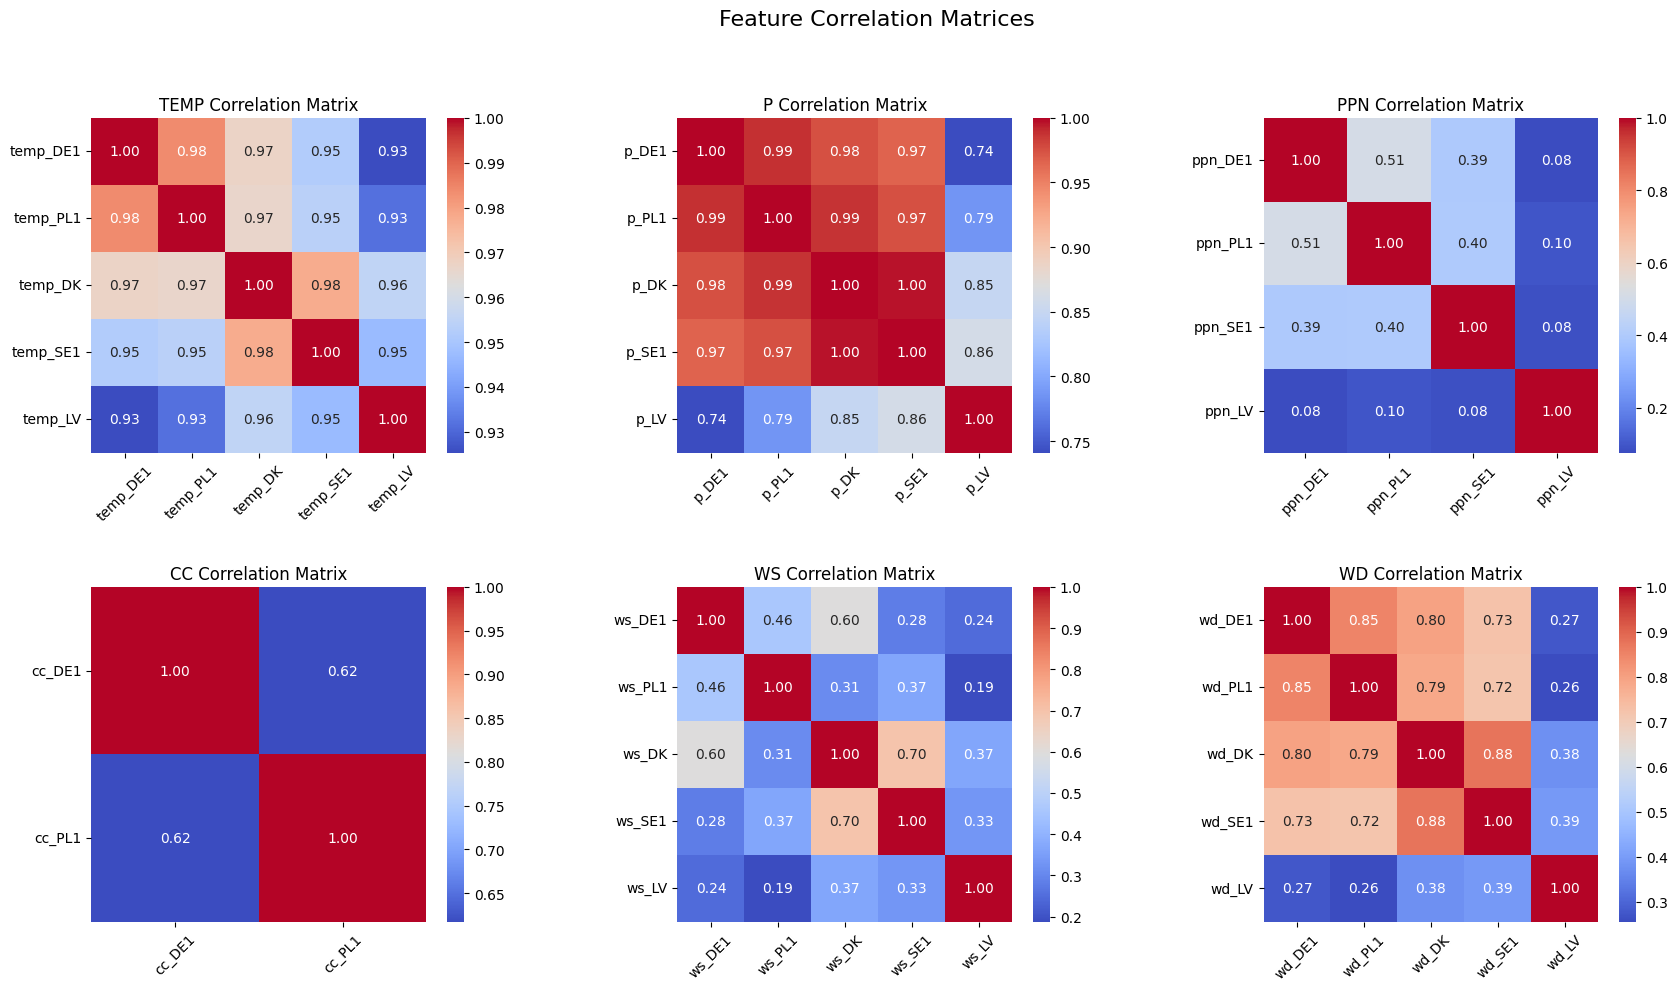

In [16]:
# Function to create and plot correlation matrix
def create_and_plot_correlation_matrix(ax, data, attribute_prefix, title):
    # Select columns that match the attribute prefix
    columns = [col for col in data.columns if col.startswith(attribute_prefix) and col.split("_")[1] != "Oie"]
    
    # Compute the correlation matrix
    if len(columns) > 1:  # Only create a heatmap if there are at least two columns
        correlation_matrix = data[columns].corr()
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=ax)
        ax.set_title(title, fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=0)
    else:
        ax.axis('off')  # Hide axes if there is not enough data
        ax.set_title(f"No data for {title}", fontsize=12)

# Create subplots for six feature types
feature_types = ['temp', 'p', 'ppn', 'cc', 'ws', 'wd']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # Two rows, three columns layout
fig.tight_layout(pad=6)  # Adjust spacing between plots

# Populate the subplots with correlation matrices
for i, feature_type in enumerate(feature_types):
    row, col = divmod(i, 3)  # Calculate the row and column index
    ax = axes[row, col]
    create_and_plot_correlation_matrix(ax, data, f"{feature_type}_", f'{feature_type.upper()} Correlation Matrix')

plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between rows and columns
plt.suptitle("Feature Correlation Matrices", fontsize=16, y=1.02)
plt.show()

In [17]:
# Cut columns
columns_to_keep = [
    "timestamp", 
    "temp_Oie", "p_Oie", "ppn_Oie",           "ws_Oie", "wd_Oie",
    "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
    "year", "spring", "month_sin", "month_cos", "day_sin", "day_cos", 
    "day_of_year_sin", "day_of_year_cos", "ringing_season", "count"
]

# Filter the dataset
filtered_data = data[columns_to_keep]

# Save the result in a new variable and print it
data = filtered_data
data.to_csv('filter2.csv', index=False)


In [18]:
# Cut columns
columns_to_keep = [
    "temp_Oie", "p_Oie", "ppn_Oie",           "ws_Oie", "wd_Oie",
    "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
    "spring", "month_sin", "month_cos", "day_sin", "day_cos",
    "count"
]

# Filter the dataset
filtered_data = data[columns_to_keep]

# Save the result in a new variable and print it
data = filtered_data
data.to_csv('filter3.csv', index=False)

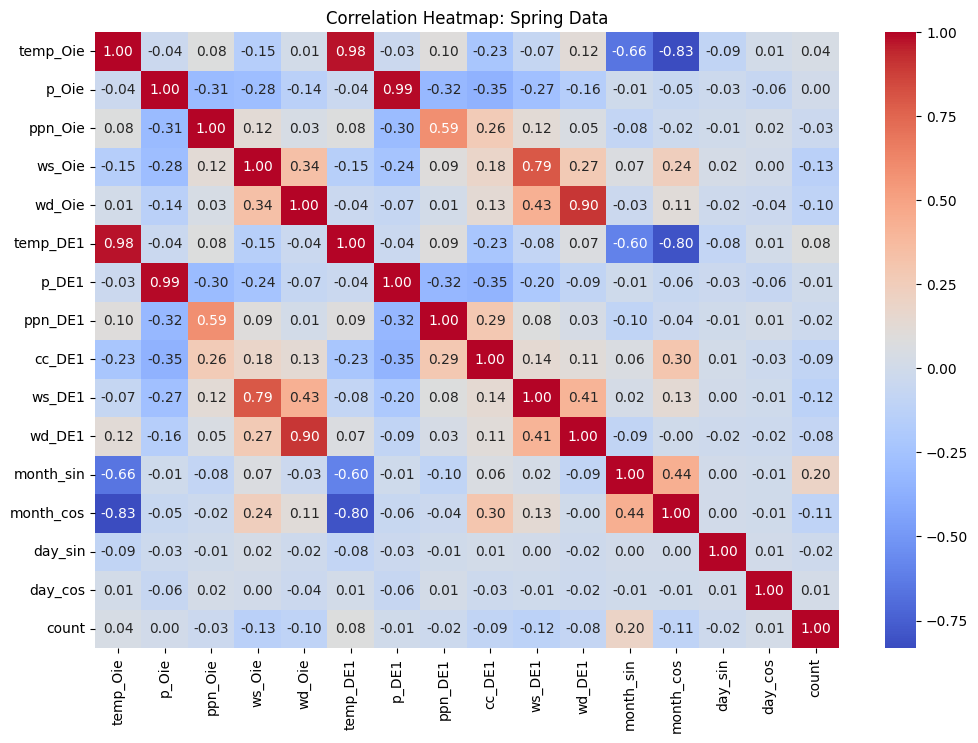

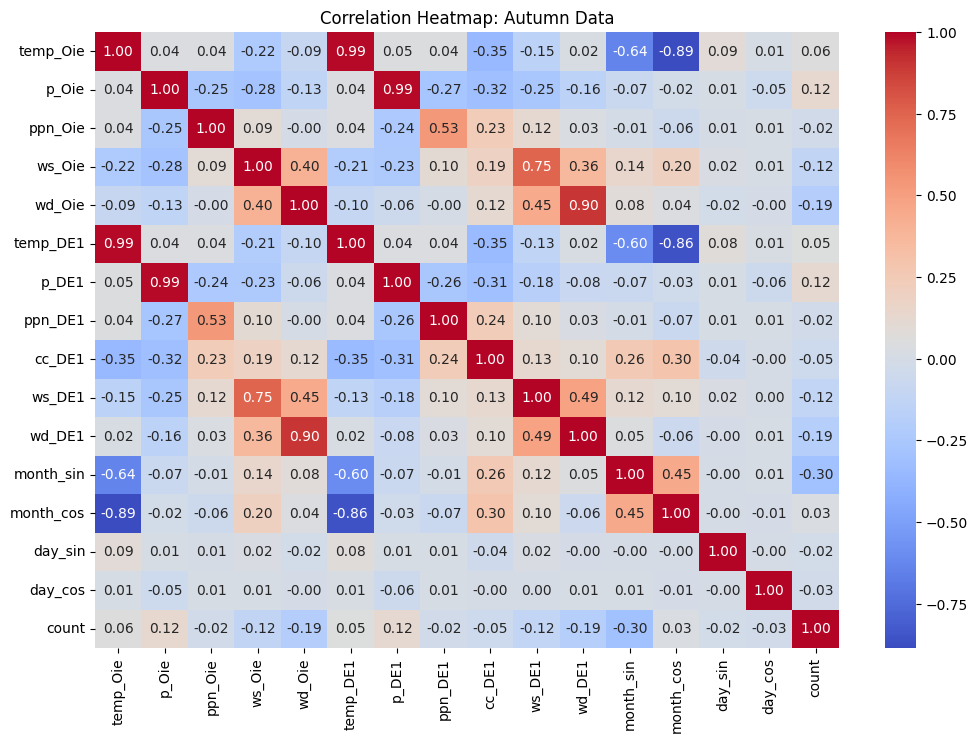

In [19]:
# Filter Relevant Columns for Predictive Modeling
predictors = ['temp_Oie', 'p_Oie', 'ppn_Oie', 'ws_Oie', 'wd_Oie', 
              "temp_DE1", "p_DE1", "ppn_DE1", "cc_DE1", "ws_DE1", "wd_DE1",
              'month_sin', 'month_cos', 'day_sin', 'day_cos']
target = 'count'

# Spring and Autumn Filtering
spring_data = data[data['spring'] == 1].apply(pd.to_numeric, errors='coerce')
autumn_data = data[data['spring'] == 0].apply(pd.to_numeric, errors='coerce')

# Function to plot correlation heatmap
def plot_correlation_heatmap(data, title):
    plt.figure(figsize=(12, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(title)
    plt.show()

# Plot heatmaps for spring and autumn
plot_correlation_heatmap(spring_data[predictors + [target]], "Correlation Heatmap: Spring Data")
plot_correlation_heatmap(autumn_data[predictors + [target]], "Correlation Heatmap: Autumn Data")

In [46]:
# Filter Relevant Columns for Predictive Modeling
predictors = ['temp_Oie', 'p_Oie', 'ppn_Oie', 'ws_Oie', 'wd_Oie', 
              "ppn_DE1", "cc_DE1",
              'month_sin', 'month_cos', 'day_sin', 'day_cos']
target = 'count'

# Spring and Autumn Filtering
spring_data = data[data['spring'] == 1].apply(pd.to_numeric, errors='coerce')
autumn_data = data[data['spring'] == 0].apply(pd.to_numeric, errors='coerce')

['temp_Oie',
 'p_Oie',
 'ppn_Oie',
 'ws_Oie',
 'wd_Oie',
 'ppn_DE1',
 'cc_DE1',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos']

In [21]:
tf.random.set_seed(42)

#Function to Prepare Data for Modeling
def prepare_data(df, predictors, target):
    X = df[predictors]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

In [22]:
# Prepare Spring Data
X_train_spring, X_test_spring, y_train_spring, y_test_spring = prepare_data(spring_data, predictors, target)

# Prepare Autumn Data
X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn = prepare_data(autumn_data, predictors, target)

# Let's check if our training and test set are homogeneous with respect to the ranges of our target:
print(np.mean(y_train_autumn),'mean train aut',np.std(y_train_autumn),'std train aut')
print(np.mean(y_test_autumn),'mean test aut',np.std(y_test_autumn),'std test aut')
print(np.mean(y_train_spring),'mean train spr',np.std(y_train_spring),'std train spr')
print(np.mean(y_test_spring),'mean test spr',np.std(y_test_spring),'std test spr')

23.697508896797153 mean train aut 73.19509473220317 std train aut
20.428679245283018 mean test aut 63.01686213506625 std test aut
11.947965941343424 mean train spr 45.79383004846644 std train spr
12.866911764705883 mean test spr 44.677166419619006 std test spr


In [23]:
# Define data structures to collect data from all Models and analyze at the end
models_spring = [] # Models names
rmse_train_spring = []  # RMSE on training data
rmse_val_spring = []    # RMSE on validation data
r2_train_spring = []  # R² on training data
r2_val_spring = []    # R² on validation data

models_autumn = [] # Models names
rmse_train_autumn = []  # RMSE on training data
rmse_val_autumn = []    # RMSE on validation data
r2_train_autumn = []  # R² on training data
r2_val_autumn = []    # R² on validation data



In [24]:
def evaluate_model(name, models, model, X_train, X_test, y_train, y_test, rmse_train, r2_train, rmse_val, r2_val):
    models.append(name)
    nn_pred_train = model.predict(X_train)
    nn_pred_test = model.predict(X_test)
    print(f'\n{name} Model:')
    print("RMSE:", np.sqrt(mean_squared_error(y_test, nn_pred_test)))
    print("R^2:", r2_score(y_test, nn_pred_test))
    
    rmse_train.append(np.sqrt(mean_squared_error(y_train, nn_pred_train)).item())
    r2_train.append(r2_score(y_train, nn_pred_train))
    rmse_val.append(np.sqrt(mean_squared_error(y_test, nn_pred_test)).item())
    r2_val.append(r2_score(y_test, nn_pred_test))

In [25]:
# Benchmark Model: Linear Regression

# Spring Linear Model
lin_reg_spring = LinearRegression()
lin_reg_spring.fit(X_train_spring, y_train_spring)
evaluate_model("Linear Spring", models_spring, lin_reg_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

# Autumn Linear Model
lin_reg_autumn = LinearRegression()
lin_reg_autumn.fit(X_train_autumn, y_train_autumn)
evaluate_model("Linear Autumn", models_autumn, lin_reg_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)


Linear Spring Model:
RMSE: 42.00579760776132
R^2: 0.11601025000030951

Linear Autumn Model:
RMSE: 58.336382518905616
R^2: 0.14303035043003087


In [26]:
# Neural Network Model 1

def build_nn_model(input_dim, l1l2=None, l2l3=None):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu', kernel_regularizer=l1l2),
        Dense(32, activation='relu', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, y_test, callback):
    return nn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=30,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=0
)

def plot_fit_history(history_spring, history_autumn):
    # Crea una figura con due subplot affiancati
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Grafico per hidden1
    ax[0].plot(history_spring.history['loss'], label='Train Loss')
    ax[0].plot(history_spring.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Spring Neural Network Training History')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    # Grafico per hidden2
    # Plot Autumn NN Training History
    ax[1].plot(history_autumn.history['loss'], label='Train Loss')
    ax[1].plot(history_autumn.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Autumn Neural Network Training History')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    
    # Mostra i grafici
    plt.tight_layout()
    plt.show()

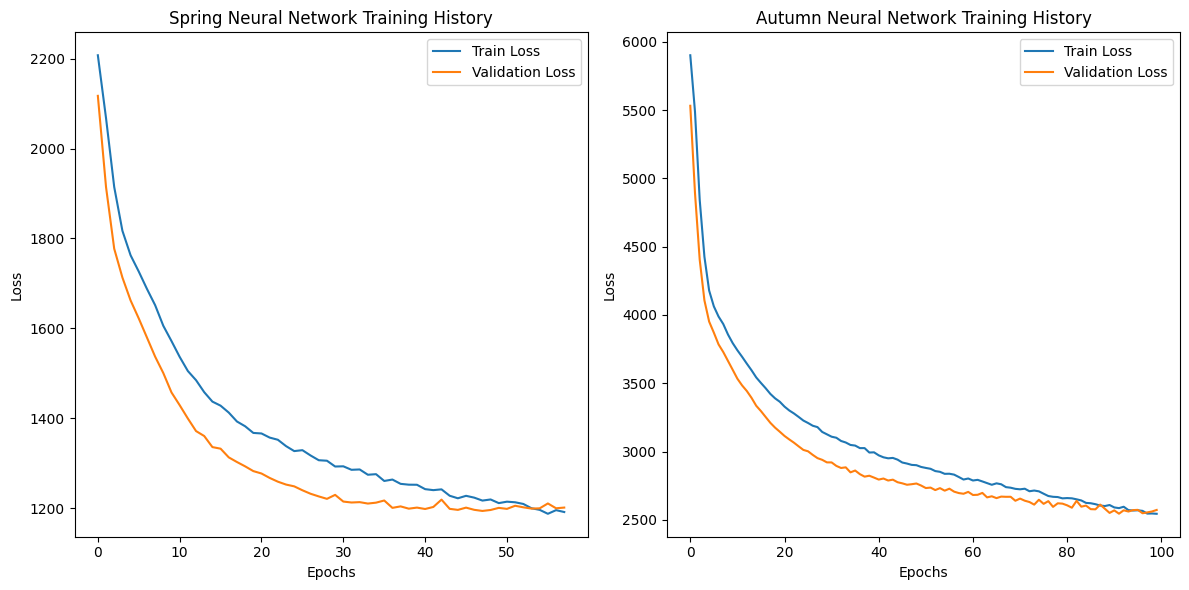

In [16]:
# Spring and Autumn Neural Network
nn_spring = build_nn_model(X_train_spring.shape[1])
nn_autumn = build_nn_model(X_train_autumn.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, early_stop)
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_spring, y_test_spring, early_stop)

plot_fit_history(history_spring, history_autumn)

In [17]:
evaluate_model("NN Spring 1.0", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 1.0", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Spring 1.0 Model:
RMSE: 38.604083919517834
R^2: 0.25338749375616165
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Autumn 1.0 Model:
RMSE: 49.10614851181732
R^2: 0.39276303962182657


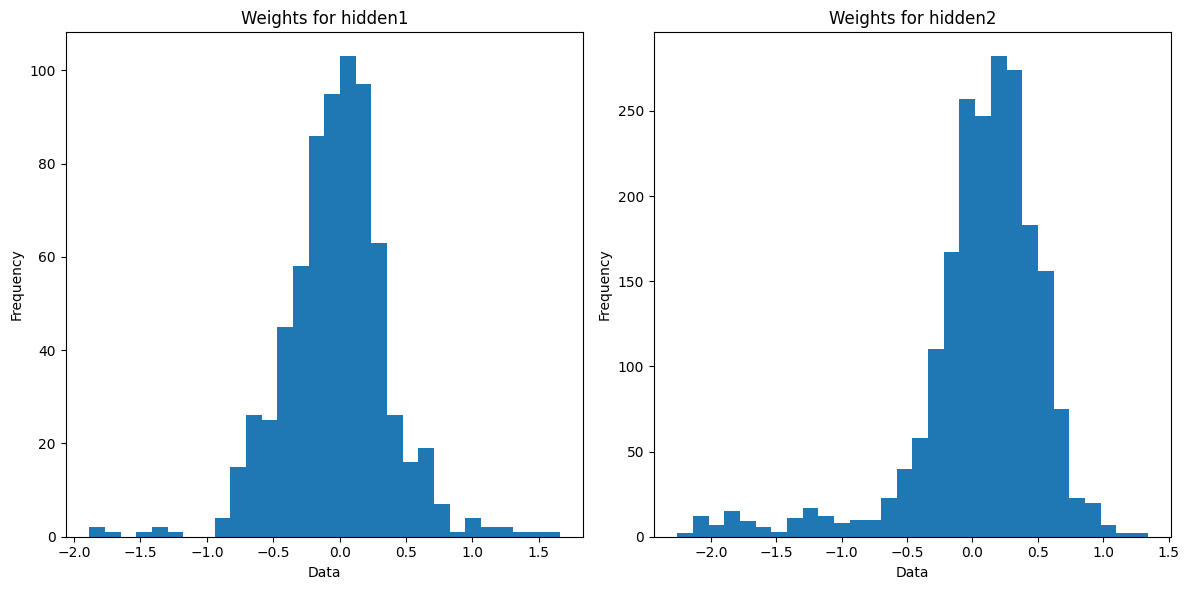

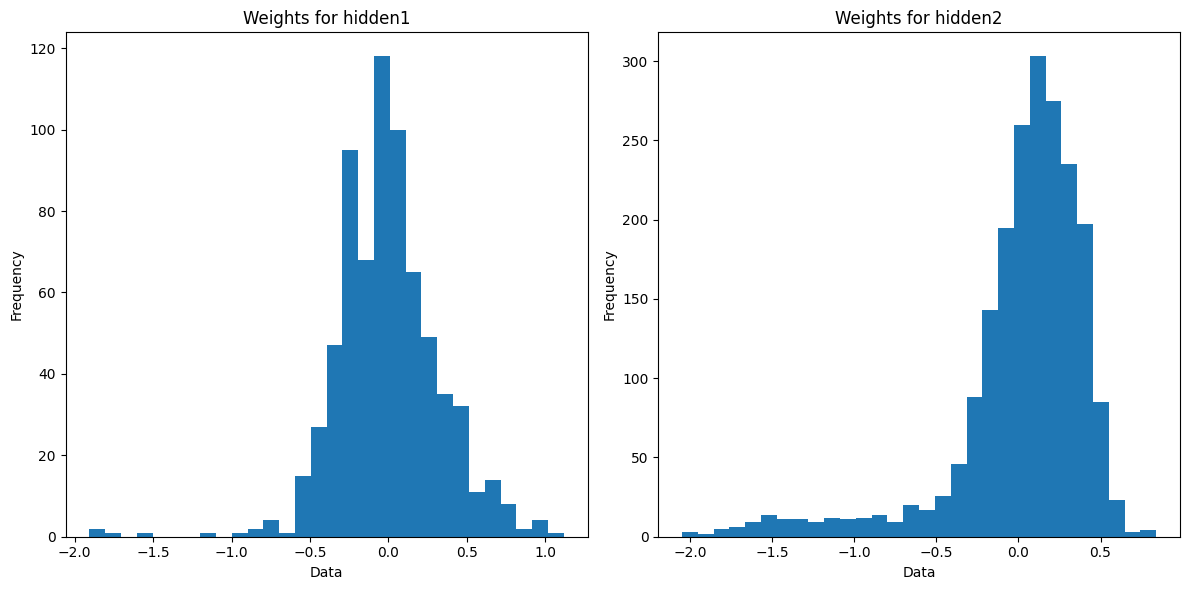

In [18]:
# Recupera i pesi e i bias dai layer
hidden1, hidden2 = nn_autumn.layers[0], nn_autumn.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

# Crea una figura con due subplot affiancati
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Grafico per hidden1
ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1')

# Grafico per hidden2
ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2')

# Mostra i grafici
plt.tight_layout()
plt.show()

# Recupera i pesi e i bias dai layer
hidden1, hidden2 = nn_spring.layers[0], nn_spring.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

# Crea una figura con due subplot affiancati
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Grafico per hidden1
ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1')

# Grafico per hidden2
ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2')

# Mostra i grafici
plt.tight_layout()
plt.show()

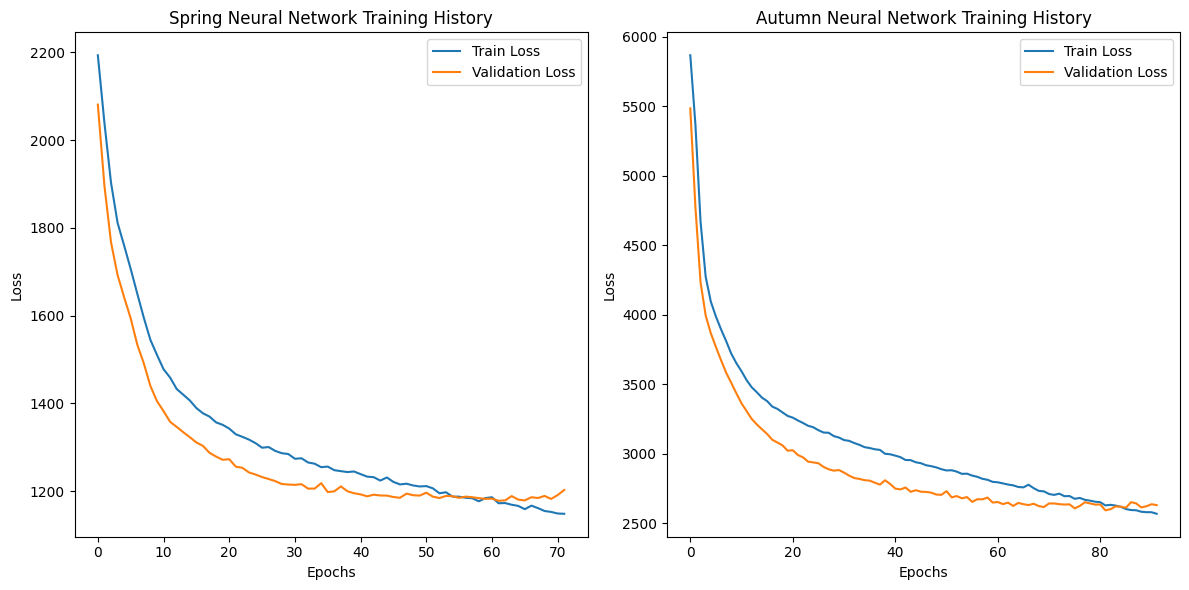

In [19]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01) # Lambda = 0.01

nn_spring = build_nn_model(X_train_spring.shape[1], l1_l2, l2_l3)
nn_autumn = build_nn_model(X_train_autumn.shape[1], l1_l2, l2_l3)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, early_stop)
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_spring, y_test_spring, early_stop)

plot_fit_history(history_spring, history_autumn)

In [20]:
evaluate_model("NN Spring 1.1", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 1.1", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Spring 1.1 Model:
RMSE: 39.180925375540966
R^2: 0.23090827929863333
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step

NN Autumn 1.1 Model:
RMSE: 49.53510769986512
R^2: 0.3821078539764866


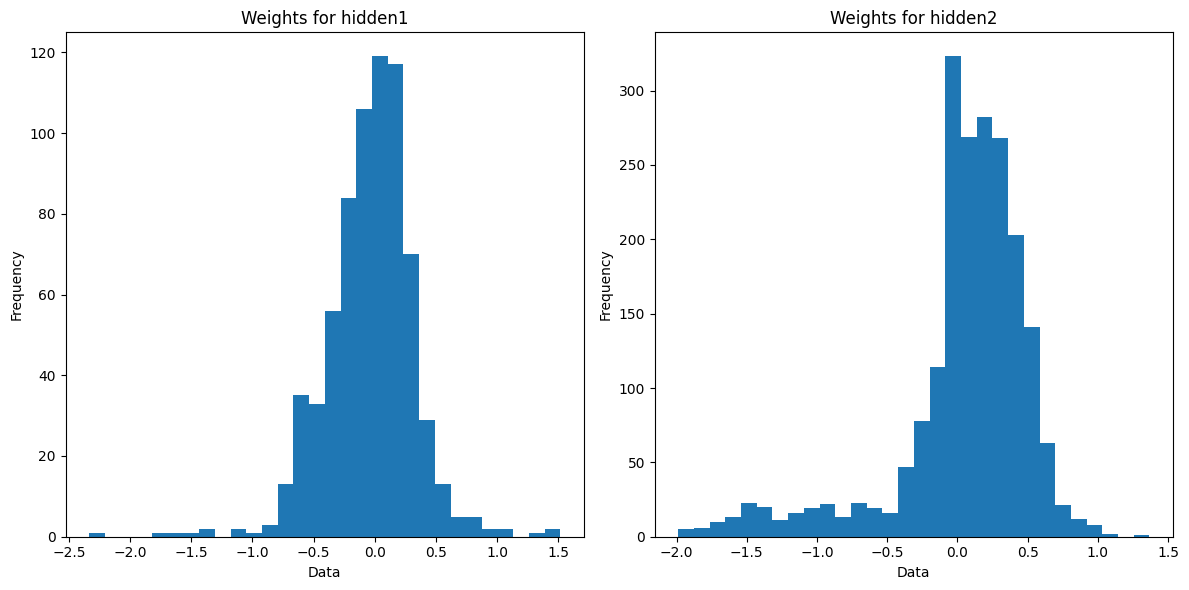

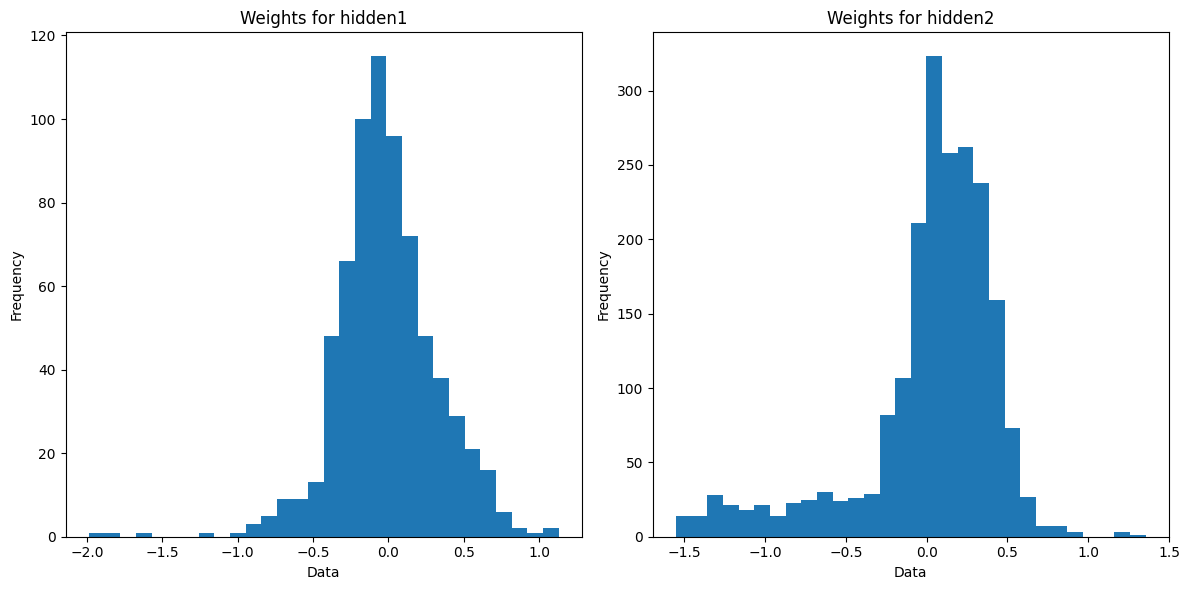

In [21]:
# Recupera i pesi e i bias dai layer
hidden1, hidden2 = nn_autumn.layers[0], nn_autumn.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

# Crea una figura con due subplot affiancati
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Grafico per hidden1
ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1')

# Grafico per hidden2
ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2')

# Mostra i grafici
plt.tight_layout()
plt.show()

# Recupera i pesi e i bias dai layer
hidden1, hidden2 = nn_spring.layers[0], nn_spring.layers[1]
weights1, biases1 = hidden1.get_weights()
weights2, biases2 = hidden2.get_weights()

# Crea una figura con due subplot affiancati
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Grafico per hidden1
ax[0].hist(np.ndarray.flatten(weights1), density=False, bins=30)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Data')
ax[0].set_title('Weights for hidden1')

# Grafico per hidden2
ax[1].hist(np.ndarray.flatten(weights2), density=False, bins=30)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Data')
ax[1].set_title('Weights for hidden2')

# Mostra i grafici
plt.tight_layout()
plt.show()

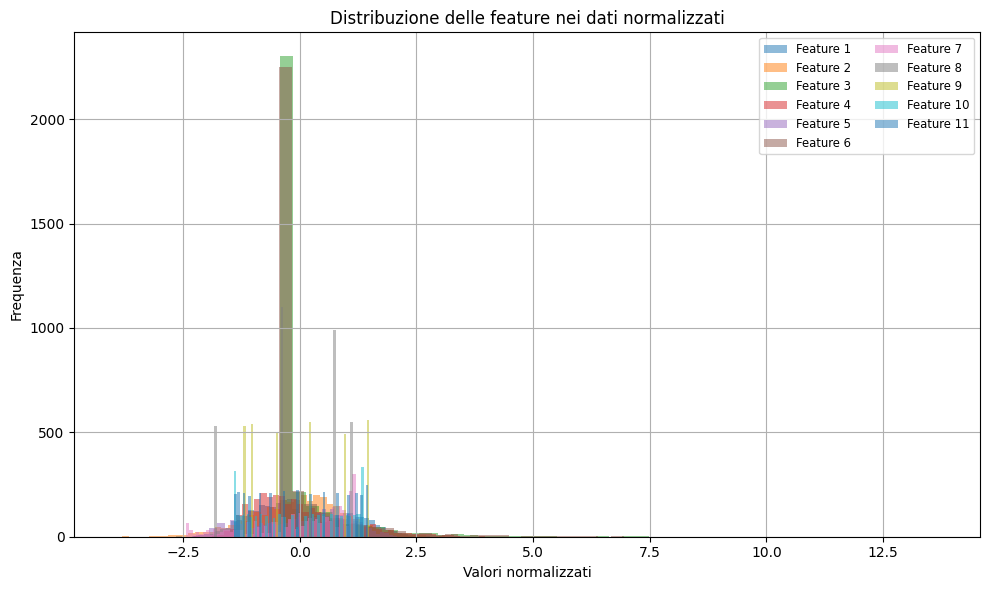

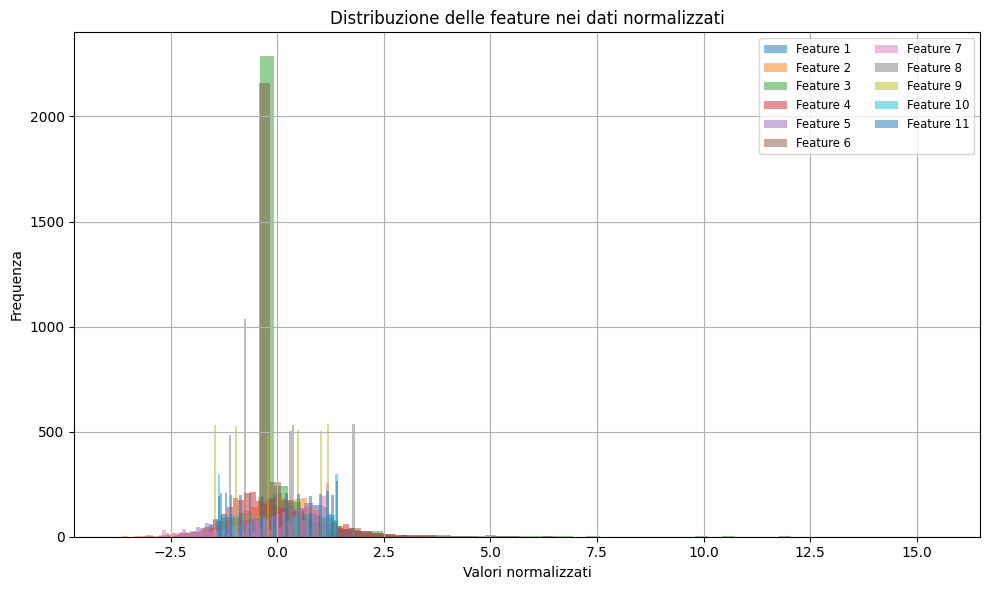

In [22]:
# Visualizza la distribuzione delle feature di x_train
plt.figure(figsize=(10, 6))
for i in range(X_train_spring.shape[1]):  # Loop per ogni feature
    plt.hist(X_train_spring[:, i], bins=50, alpha=0.5, label=f'Feature {i+1}')

plt.title("Distribuzione delle feature nei dati normalizzati")
plt.xlabel("Valori normalizzati")
plt.ylabel("Frequenza")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualizza la distribuzione delle feature di x_train
plt.figure(figsize=(10, 6))
for i in range(X_train_autumn.shape[1]):  # Loop per ogni feature
    plt.hist(X_train_autumn[:, i], bins=50, alpha=0.5, label=f'Feature {i+1}')

plt.title("Distribuzione delle feature nei dati normalizzati")
plt.xlabel("Valori normalizzati")
plt.ylabel("Frequenza")
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
def build_nn_model(input_dim, l1l2=None, l2l3=None):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='tanh', kernel_regularizer=l1l2),
        Dense(32, activation='tanh', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, y_test, callback):
    return nn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=30,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=0
)

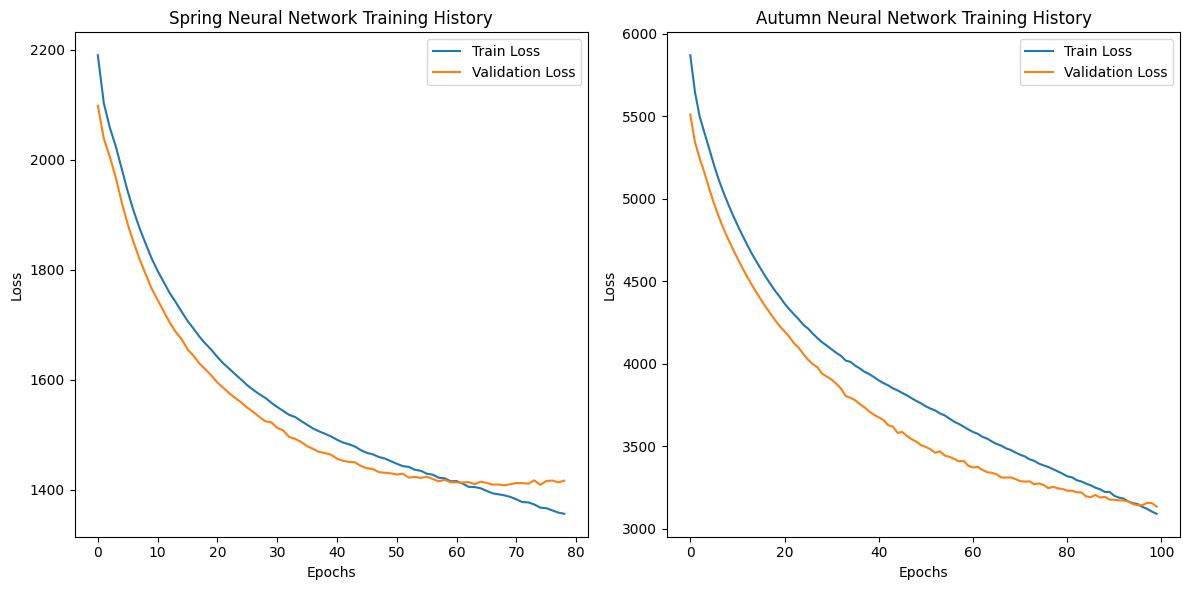

In [24]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01) # Lambda = 0.01

nn_spring = build_nn_model(X_train_spring.shape[1], l1_l2, l2_l3)
nn_autumn = build_nn_model(X_train_autumn.shape[1], l1_l2, l2_l3)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, early_stop)
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_spring, y_test_spring, early_stop)

plot_fit_history(history_spring, history_autumn)

In [25]:
evaluate_model("NN Spring 2.0", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.0", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Spring 2.0 Model:
RMSE: 37.32919791178629
R^2: 0.30188643785156644
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Autumn 2.0 Model:
RMSE: 51.683264216462554
R^2: 0.32735437480475704


In [26]:
def build_nn_model(input_dim, l1l2=None, l2l3=None):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='tanh', kernel_regularizer=l1l2),
        Dense(32, activation='tanh', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, y_test, callback):
    return nn.fit(
    X_train, y_train,
    shuffle=True,
    epochs=400,
    batch_size=100,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=0)

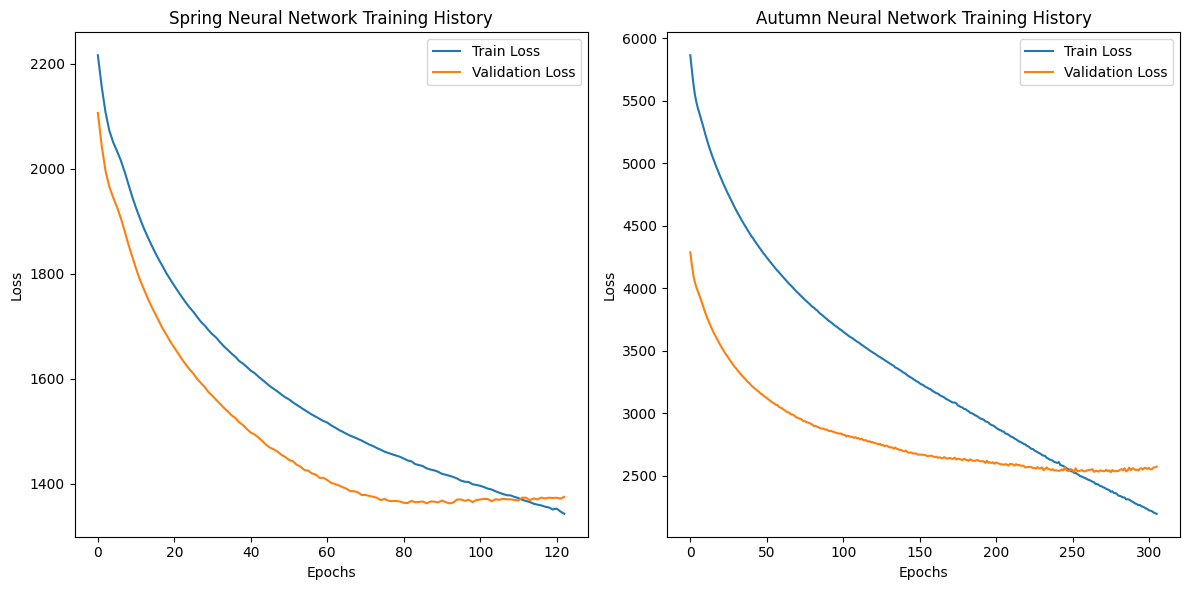

In [27]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01

early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) # Increase our patience

nn_spring = build_nn_model(X_train_spring.shape[1], l1_l2, l2_l3)
nn_autumn = build_nn_model(X_train_autumn.shape[1], l1_l2, l2_l3)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, early_stop)

plot_fit_history(history_spring, history_autumn)

In [28]:
evaluate_model("NN Spring 2.1", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.1", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Spring 2.1 Model:
RMSE: 36.898422853161456
R^2: 0.3179057863215512
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Autumn 2.1 Model:
RMSE: 50.25630080796229
R^2: 0.3639848088359995


In [29]:
#Define Callback to log activations

class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, model, layer_name, data):
        self.mymodel = model
        self.layer_name = layer_name
        self.data = data
        self.epoch_activations = []

    def on_epoch_end(self, epoch, logs=None):
        # Silence the output here
        layer_output = tf.keras.Model(
            inputs=self.mymodel.input,
            outputs=self.mymodel.get_layer(self.layer_name).output
        )
        # Calculate activations without printing
        activation_values = layer_output(self.data, training=False)
        self.epoch_activations.append(activation_values.numpy())

def NeuronsActivationReport(neurons_l1, neurons_l2, X_train, y_train, X_test, y_test):
    # Set random seed
    tf.random.set_seed(42)
    
    # Define regularizers
    l1_l2 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
    l2_l3 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    # Define the model
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(neurons_l1, activation='tanh', kernel_regularizer=l1_l2, name='dense1')(inputs)
    y = tf.keras.layers.Dense(neurons_l2, activation='tanh', kernel_regularizer=l2_l3, name='dense2')(x)
    outputs = tf.keras.layers.Dense(1)(y)
    NNRegModel = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    NNRegModel.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    # Prepare callbacks for activations
    activation_logger_dense1 = ActivationLogger(NNRegModel, layer_name='dense1', data=X_train)
    activation_logger_dense2 = ActivationLogger(NNRegModel, layer_name='dense2', data=X_train)
    
    # Explicitly call the model with a dummy input
    dummy_input = tf.random.normal((1, X_train.shape[1]))
    NNRegModel(dummy_input)
    
    # Fit the model
    NNRegModel.fit(
        X_train, y_train,
        shuffle=True,
        epochs=100,
        batch_size=100,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[activation_logger_dense1, activation_logger_dense2]
    )

    # Analyze activations for dense1
    all_epoch_activations_dense1 = np.array(activation_logger_dense1.epoch_activations)  # Shape: (epochs, samples, neurons)
    transposed_activations_dense1 = np.transpose(all_epoch_activations_dense1, (2, 0, 1))  # (neurons, epochs, samples)
    flattened_activations_dense1 = transposed_activations_dense1.reshape(transposed_activations_dense1.shape[0], -1)
    # Correlation for dense1
    correlation_matrix_dense1 = np.corrcoef(flattened_activations_dense1)
    
    # Analyze activations for dense2
    all_epoch_activations_dense2 = np.array(activation_logger_dense2.epoch_activations)  # Shape: (epochs, samples, neurons)
    transposed_activations_dense2 = np.transpose(all_epoch_activations_dense2, (2, 0, 1))  # (neurons, epochs, samples)
    flattened_activations_dense2 = transposed_activations_dense2.reshape(transposed_activations_dense2.shape[0], -1)
    # Correlation for dense2
    correlation_matrix_dense2 = np.corrcoef(flattened_activations_dense2)
    
    # Plot both correlation matrices in a single row
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # Create a single row with two plots
    
    # Plot dense1 correlation matrix
    sns.heatmap(correlation_matrix_dense1, annot=False, cmap='coolwarm', ax=axes[0])
    axes[0].set_title('Neuron Activation Hidden 1')
    axes[0].set_xlabel('Neurons')
    axes[0].set_ylabel('Neurons')
    
    # Plot dense2 correlation matrix
    sns.heatmap(correlation_matrix_dense2, annot=False, cmap='coolwarm', ax=axes[1])
    axes[1].set_title('Neuron Activation Hidden 2')
    axes[1].set_xlabel('Neurons')
    axes[1].set_ylabel('Neurons')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

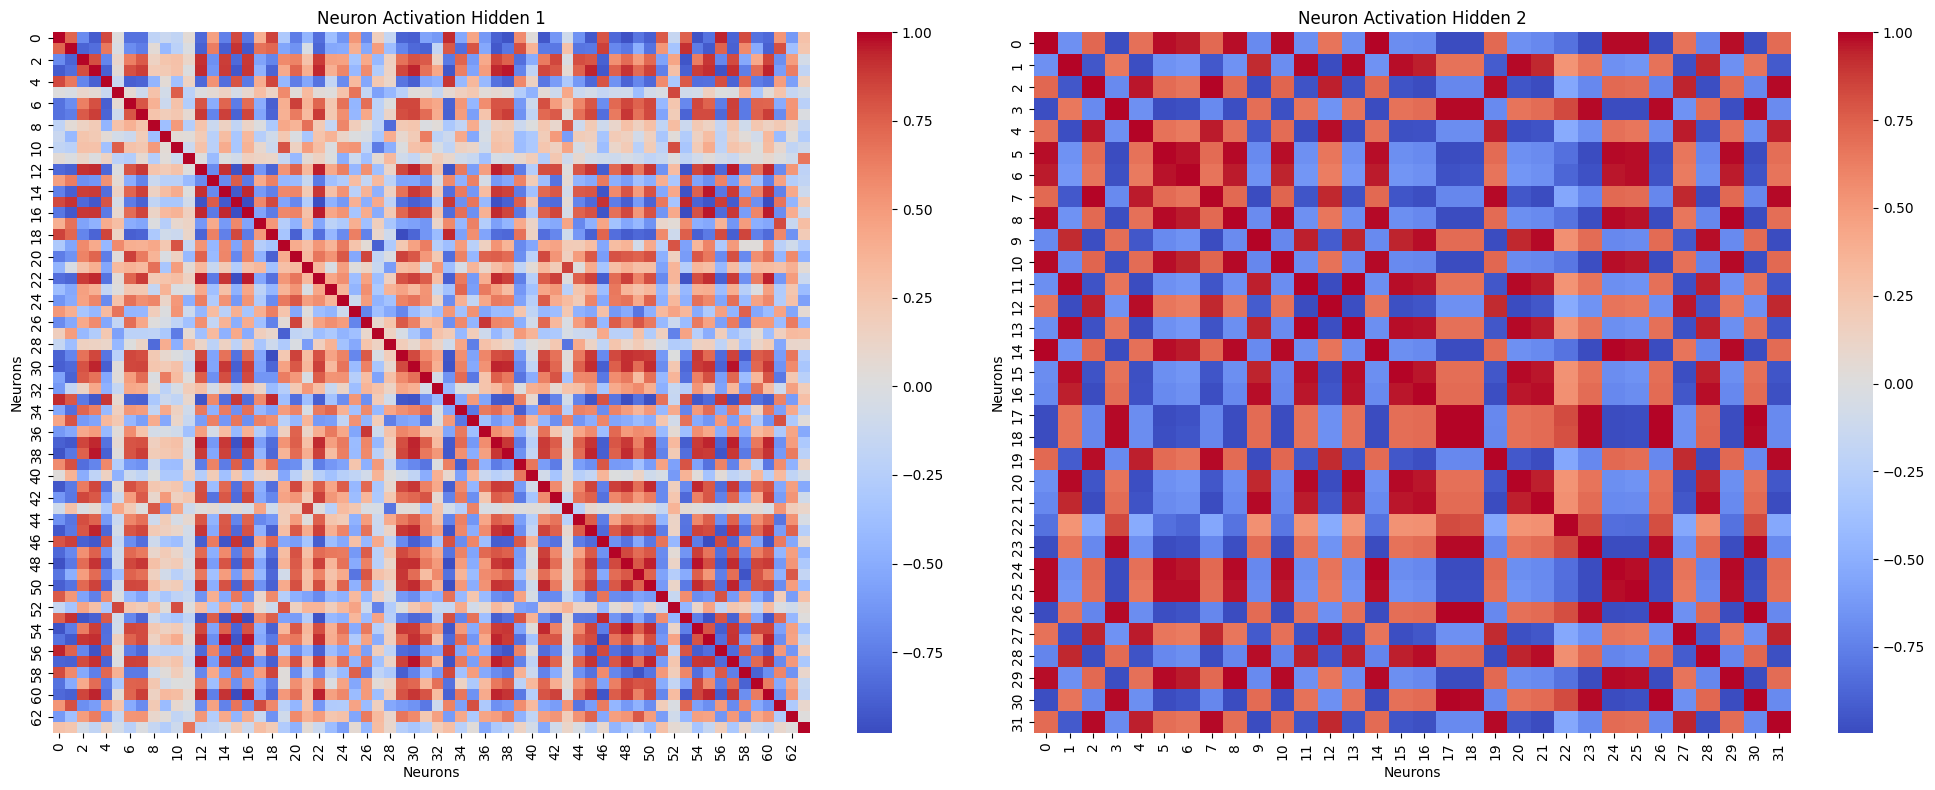

In [30]:
NeuronsActivationReport(64, 32, X_train_spring, y_train_spring, X_test_spring, y_test_spring)

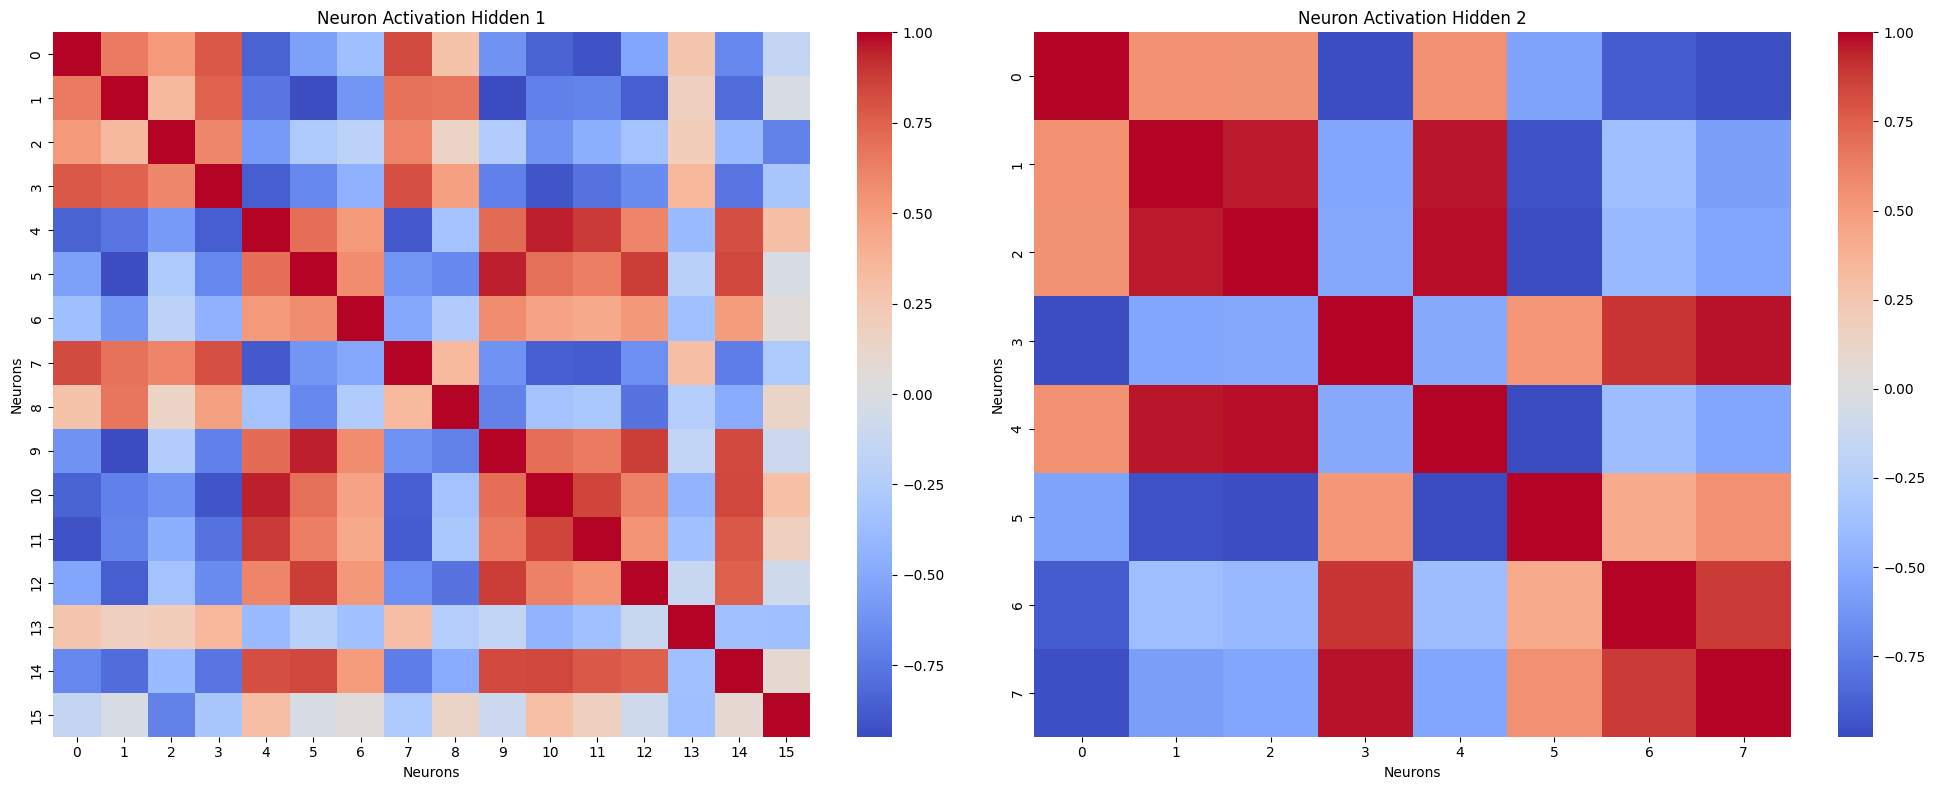

In [31]:
# Let's find a better solution, reducing number of neurons (if possible)
NeuronsActivationReport(16, 8, X_train_spring, y_train_spring, X_test_spring, y_test_spring)

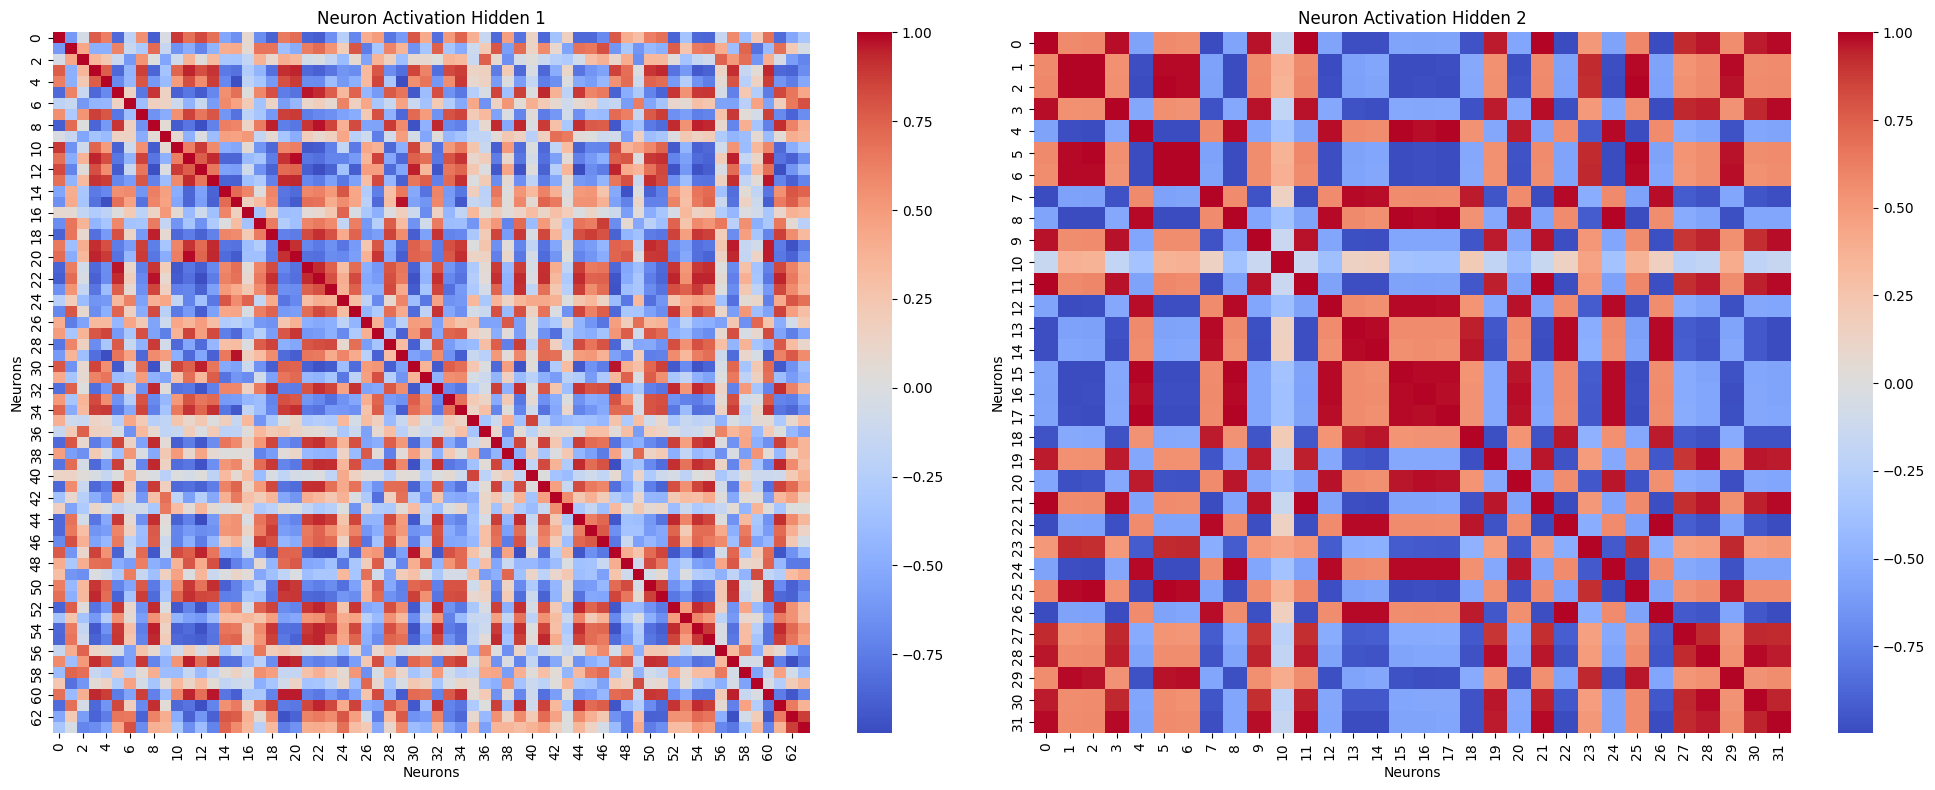

In [32]:
NeuronsActivationReport(64, 32, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn)

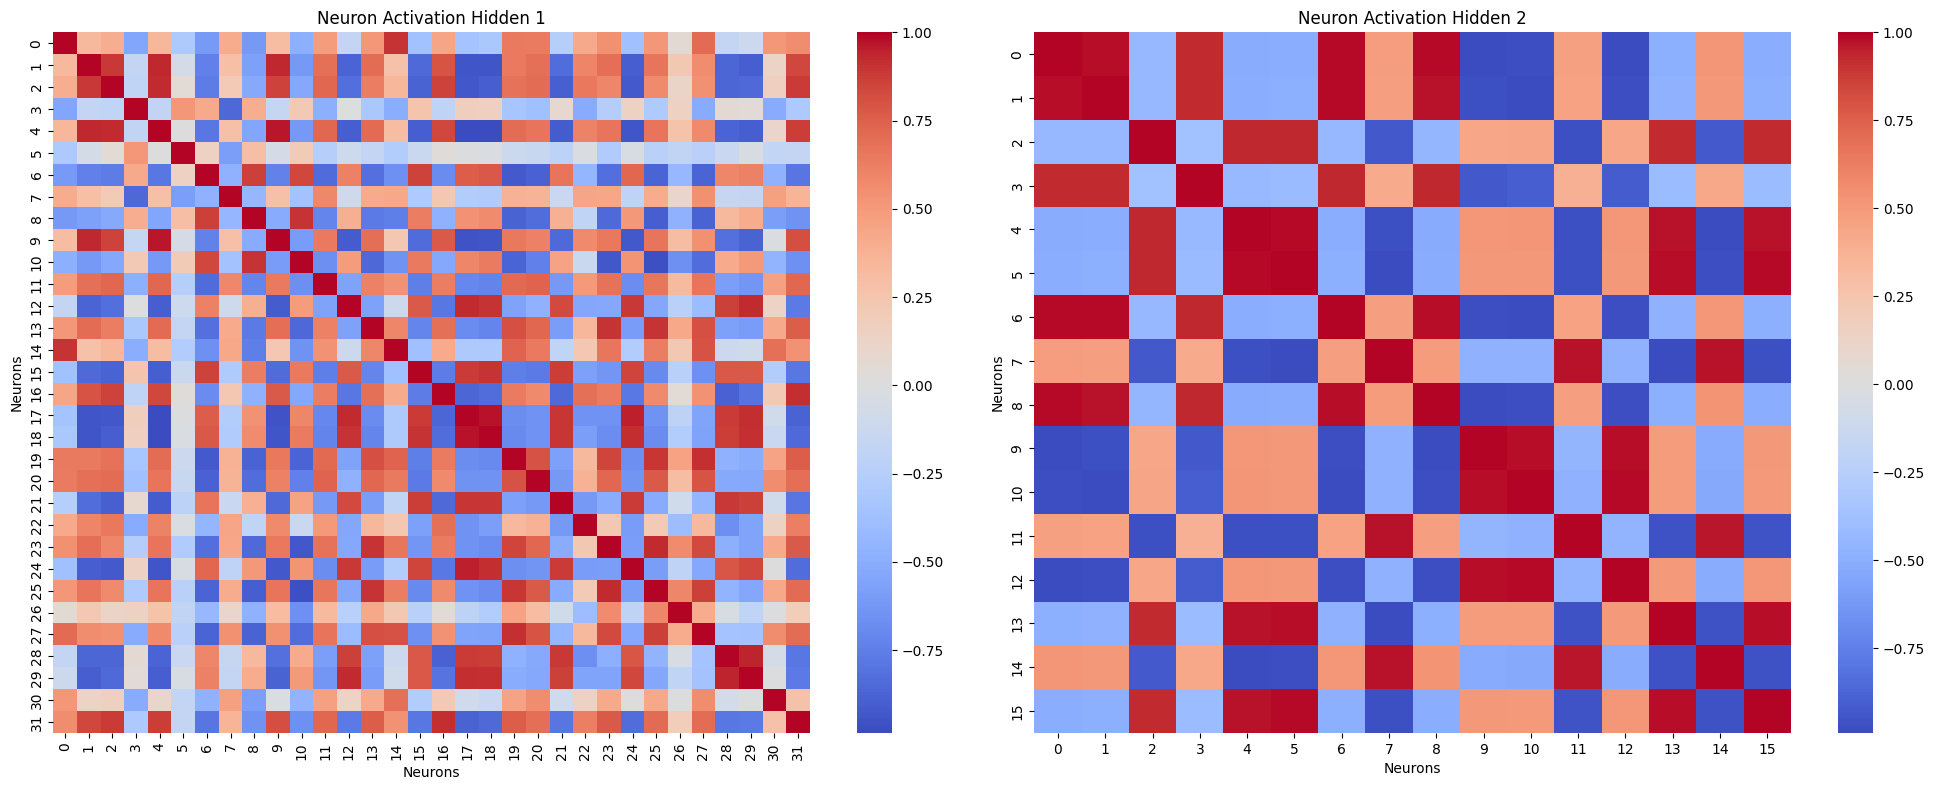

In [33]:
# Let's find a better solution, reducing number of neurons (if possible)
NeuronsActivationReport(32, 16, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn)

In [34]:
def build_nn_model(input_dim, neurons_l1, neurons_l2, l1l2=None, l2l3=None):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='tanh', kernel_regularizer=l1l2),
        Dense(neurons_l2, activation='tanh', kernel_regularizer=l2l3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, Y_test, callback):
    return nn.fit(
    X_train, y_train,
    shuffle=True,
    epochs=200,
    batch_size=30,
    callbacks=[callback],
    validation_data=(X_test, Y_test),
    verbose=0)

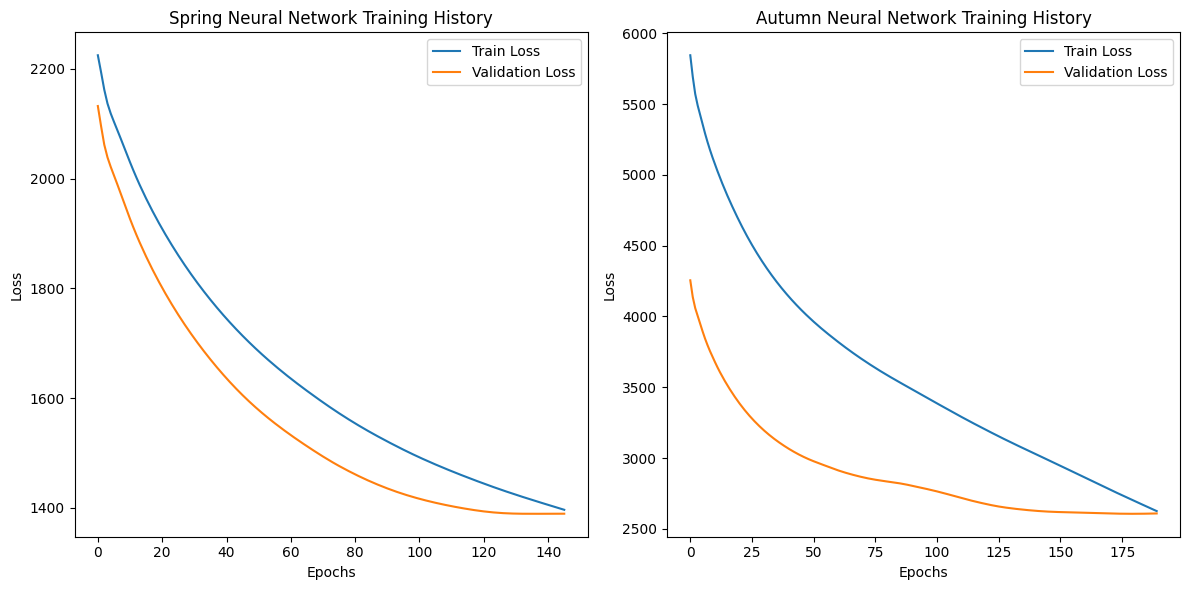

In [35]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Increase our patience

nn_spring = build_nn_model(X_train_spring.shape[1], 16, 8, l1_l2, l2_l3)
nn_autumn = build_nn_model(X_train_autumn.shape[1], 32, 16, l1_l2, l2_l3)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, early_stop)

plot_fit_history(history_spring, history_autumn)

In [36]:
evaluate_model("NN Spring 2.2", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.2", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Spring 2.2 Model:
RMSE: 37.264554145989955
R^2: 0.30430222050843525
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

NN Autumn 2.2 Model:
RMSE: 51.04138061129133
R^2: 0.3439585529156767


In [41]:
def build_nn_model(input_dim, neurons_l1, l1l2=None):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='tanh', kernel_regularizer=l1l2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, Y_test, callback):
    return nn.fit(
    X_train, y_train,
    shuffle=True,
    epochs=500,
    batch_size=30,
    callbacks=[callback],
    validation_data=(X_test, Y_test),
    verbose=0)

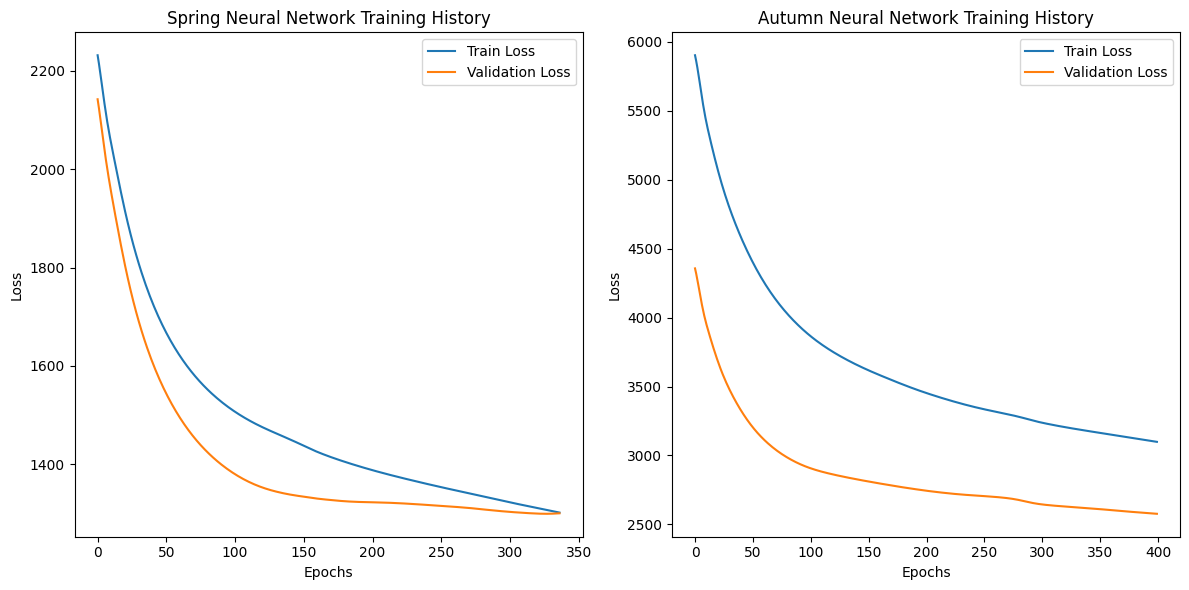

In [42]:
l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Increase our patience

nn_spring = build_nn_model(X_train_spring.shape[1], 16, l1_l2)
nn_autumn = build_nn_model(X_train_autumn.shape[1], 32, l1_l2)

history_spring = fit_nn_model(nn_spring, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
history_autumn = fit_nn_model(nn_autumn, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, [early_stop])

plot_fit_history(history_spring, history_autumn)

In [43]:
evaluate_model("NN Spring 2.3", models_spring, nn_spring, 
                  X_train_spring, X_test_spring, y_train_spring, y_test_spring, 
                  rmse_train_spring, r2_train_spring, rmse_val_spring, r2_val_spring)

evaluate_model("NN Autumn 2.3", models_autumn, nn_autumn, 
                  X_train_autumn, X_test_autumn, y_train_autumn, y_test_autumn, 
                  rmse_train_autumn, r2_train_autumn, rmse_val_autumn, r2_val_autumn)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

NN Spring 2.3 Model:
RMSE: 36.04129250985566
R^2: 0.3492270800512266
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

NN Autumn 2.3 Model:
RMSE: 50.753186040351565
R^2: 0.35134604187668805


In [35]:
#Define Callback to log activations

class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, model, layer_name, data):
        self.mymodel = model
        self.layer_name = layer_name
        self.data = data
        self.epoch_activations = []

    def on_epoch_end(self, epoch, logs=None):
        # Silence the output here
        layer_output = tf.keras.Model(
            inputs=self.mymodel.input,
            outputs=self.mymodel.get_layer(self.layer_name).output
        )
        # Calculate activations without printing
        activation_values = layer_output(self.data, training=False)
        self.epoch_activations.append(activation_values.numpy())

def NeuronsActivationReport(neurons_l1, X_train, y_train, X_test, y_test):
    # Set random seed
    tf.random.set_seed(42)
    
    # Define regularizers
    l1_l2 = tf.keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    # Define the model
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    x = tf.keras.layers.Dense(neurons_l1, activation='tanh', kernel_regularizer=l1_l2, name='dense')(inputs)
    outputs = tf.keras.layers.Dense(1)(x)
    NNRegModel = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    NNRegModel.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    # Prepare callbacks for activations
    activation_logger_dense = ActivationLogger(NNRegModel, layer_name='dense', data=X_train)
    
    # Explicitly call the model with a dummy input
    dummy_input = tf.random.normal((1, X_train.shape[1]))
    NNRegModel(dummy_input)
    
    # Fit the model
    NNRegModel.fit(
        X_train, y_train,
        shuffle=True,
        epochs=200,
        batch_size=30,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[activation_logger_dense]
    )

    # Analyze activations for dense1
    all_epoch_activations_dense = np.array(activation_logger_dense.epoch_activations)  # Shape: (epochs, samples, neurons)
    transposed_activations_dense = np.transpose(all_epoch_activations_dense, (2, 0, 1))  # (neurons, epochs, samples)
    flattened_activations_dense = transposed_activations_dense.reshape(transposed_activations_dense.shape[0], -1)
    # Correlation for dense1
    correlation_matrix_dense = np.corrcoef(flattened_activations_dense)
    
    # Plot both correlation matrices in a single row
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot dense correlation matrix
    sns.heatmap(correlation_matrix_dense, annot=False, cmap='coolwarm', ax=axes[0])
    axes[0].set_title('Neuron Activation Hidden 1')
    axes[0].set_xlabel('Neurons')
    axes[0].set_ylabel('Neurons')
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [ ]:
NeuronsActivationReport(16, X_train_spring, y_train_spring, X_test_spring, y_test_spring)

In [ ]:
NeuronsActivationReport(32, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn)

In [42]:
def build_nn_model(input_dim, neurons_l1, l1l2=None):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(neurons_l1, activation='tanh', kernel_regularizer=l1l2),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def fit_nn_model(nn, X_train, y_train, X_test, Y_test, callback):
    nn.fit(X_train, y_train,
    shuffle=True,
    epochs=500,
    batch_size=30,
    callbacks=[callback],
    validation_data=(X_test, Y_test),
    verbose=0)

l1_l2=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01
l2_l3=tf.keras.regularizers.L1L2(l1=0.001, l2=0.001) # Lambda = 0.01

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Increase our patience

nn_spring = build_nn_model(X_train_spring.shape[1], 16, l1_l2)
nn_autumn = build_nn_model(X_train_autumn.shape[1], 32, l1_l2)

# create directory for models
#from os import makedirs
#makedirs('bm_models')

# fit and save models
n_members = 10
for i in range(n_members):
    # fit model
    model = build_nn_model(X_train_spring.shape[1], 16, 8, l1_l2, l2_l3)
    fit_nn_model(model, X_train_spring, y_train_spring, X_test_spring, y_test_spring, [early_stop])
    # save model
    filename = 'bm_models/spr_model_' + str(i + 1) + '.keras'
    model.save(filename)
    print('>Saved %s' % filename)

for i in range(n_members):
    # fit model
    model = build_nn_model(X_train_autumn.shape[1], 32, 16, l1_l2, l2_l3)
    fit_nn_model(model, X_train_autumn, y_train_autumn, X_test_autumn, y_test_autumn, [early_stop])
    # save model
    filename = 'bm_models/aut_model_' + str(i + 1) + '.keras'
    model.save(filename)
    print('>Saved %s' % filename)

>Saved bm_models/spr_model_1.keras
>Saved bm_models/spr_model_2.keras
>Saved bm_models/spr_model_3.keras
>Saved bm_models/spr_model_4.keras
>Saved bm_models/spr_model_5.keras
>Saved bm_models/spr_model_6.keras
>Saved bm_models/spr_model_7.keras
>Saved bm_models/spr_model_8.keras
>Saved bm_models/spr_model_9.keras
>Saved bm_models/spr_model_10.keras
>Saved bm_models/aut_model_1.keras
>Saved bm_models/aut_model_2.keras
>Saved bm_models/aut_model_3.keras
>Saved bm_models/aut_model_4.keras
>Saved bm_models/aut_model_5.keras
>Saved bm_models/aut_model_6.keras
>Saved bm_models/aut_model_7.keras
>Saved bm_models/aut_model_8.keras
>Saved bm_models/aut_model_9.keras
>Saved bm_models/aut_model_10.keras


In [48]:
# load models from file
def load_all_models(n_models, prefix):
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = f'bm_models/{prefix}_model_' + str(i + 1) + '.keras'
        # load model from file
        model = tf.keras.models.load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [49]:
# load spr models
n_members = 10
spr_members = load_all_models(n_members, 'spr')
print('Loaded %d models' % len(spr_members))
# load aut models
aut_members = load_all_models(n_members, 'aut')
print('Loaded %d models' % len(aut_members))

>loaded bm_models/spr_model_1.keras
>loaded bm_models/spr_model_2.keras
>loaded bm_models/spr_model_3.keras
>loaded bm_models/spr_model_4.keras
>loaded bm_models/spr_model_5.keras
>loaded bm_models/spr_model_6.keras
>loaded bm_models/spr_model_7.keras
>loaded bm_models/spr_model_8.keras
>loaded bm_models/spr_model_9.keras
>loaded bm_models/spr_model_10.keras
Loaded 10 models
>loaded bm_models/aut_model_1.keras
>loaded bm_models/aut_model_2.keras
>loaded bm_models/aut_model_3.keras
>loaded bm_models/aut_model_4.keras
>loaded bm_models/aut_model_5.keras
>loaded bm_models/aut_model_6.keras
>loaded bm_models/aut_model_7.keras
>loaded bm_models/aut_model_8.keras
>loaded bm_models/aut_model_9.keras
>loaded bm_models/aut_model_10.keras
Loaded 10 models


In [50]:
spr_mse_train, spr_mse, spr_r2_train, spr_r2 = 0, 0, 0, 0
aut_mse_train, aut_mse, aut_r2_train, aut_r2 = 0, 0, 0, 0

for model in spr_members:
    nn_pred_train = model.predict(X_train_spring)
    nn_pred_test = model.predict(X_test_spring)
    spr_mse_train += np.sqrt(mean_squared_error(y_train_spring, nn_pred_train)).item()
    spr_r2_train += r2_score(y_train_spring, nn_pred_train)
    spr_mse += np.sqrt(mean_squared_error(y_test_spring, nn_pred_test)).item()
    spr_r2 += r2_score(y_test_spring, nn_pred_test)
for model in aut_members:
    nn_pred_train = model.predict(X_train_autumn)
    nn_pred_test = model.predict(X_test_autumn)
    aut_mse_train += np.sqrt(mean_squared_error(y_train_autumn, nn_pred_train)).item()
    aut_r2_train += r2_score(y_train_autumn, nn_pred_train)
    aut_mse += np.sqrt(mean_squared_error(y_test_autumn, nn_pred_test)).item()
    aut_r2 += r2_score(y_test_autumn, nn_pred_test)

models_spring.append("Ens NN 3.0")
rmse_train_spring.append(spr_mse_train / 10)
r2_train_spring.append(spr_r2_train / 10)
rmse_val_spring.append(spr_mse / 10)
r2_val_spring.append(spr_r2 / 10)

models_autumn.append("Ens NN 3.0")
rmse_train_autumn.append(aut_mse_train / 10)
r2_train_autumn.append(aut_r2_train / 10)
rmse_val_autumn.append(aut_mse / 10)
r2_val_autumn.append(aut_r2 / 10)

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/s

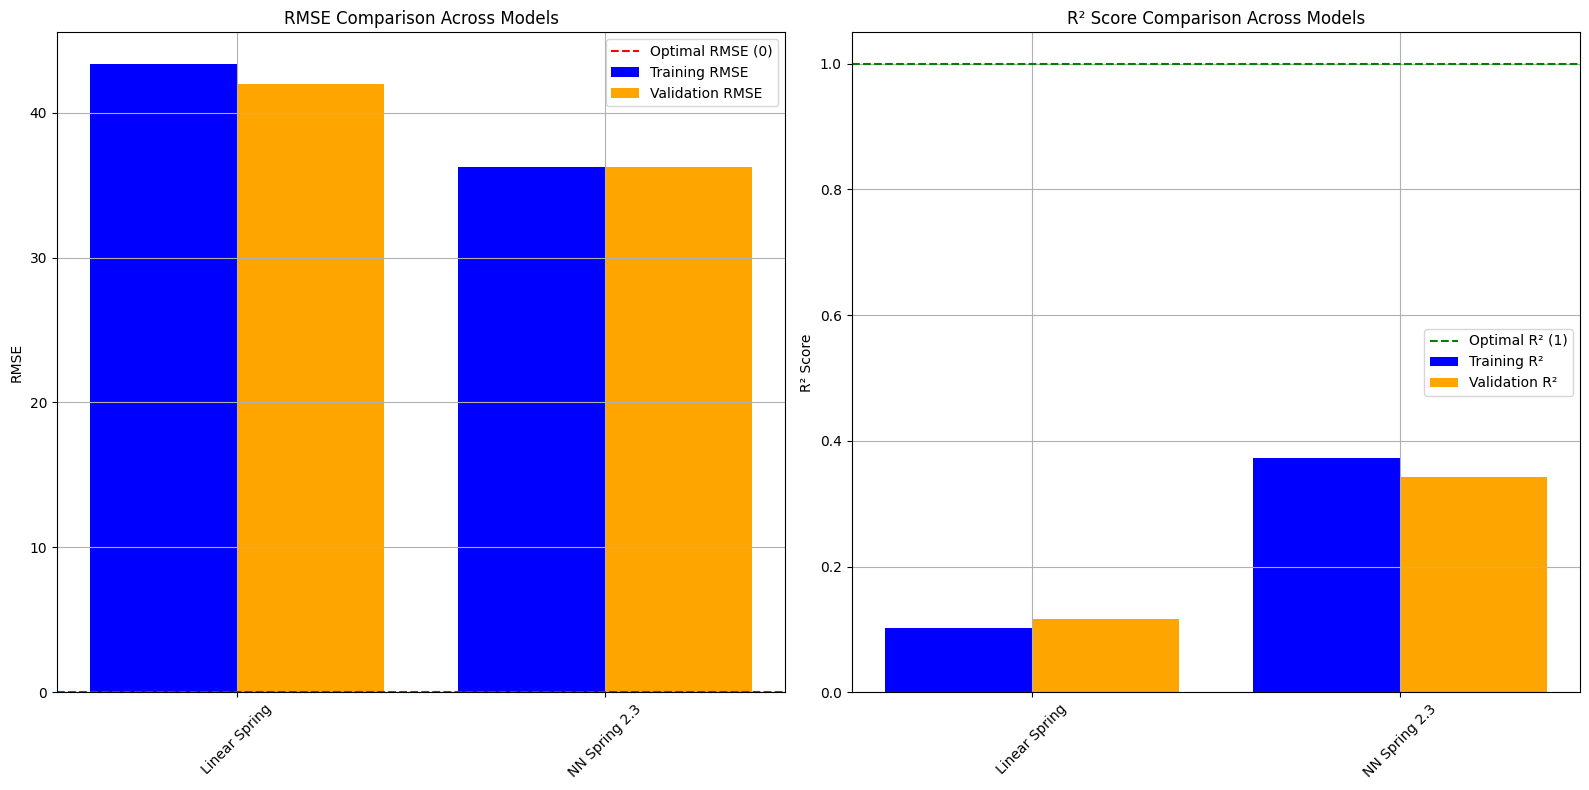

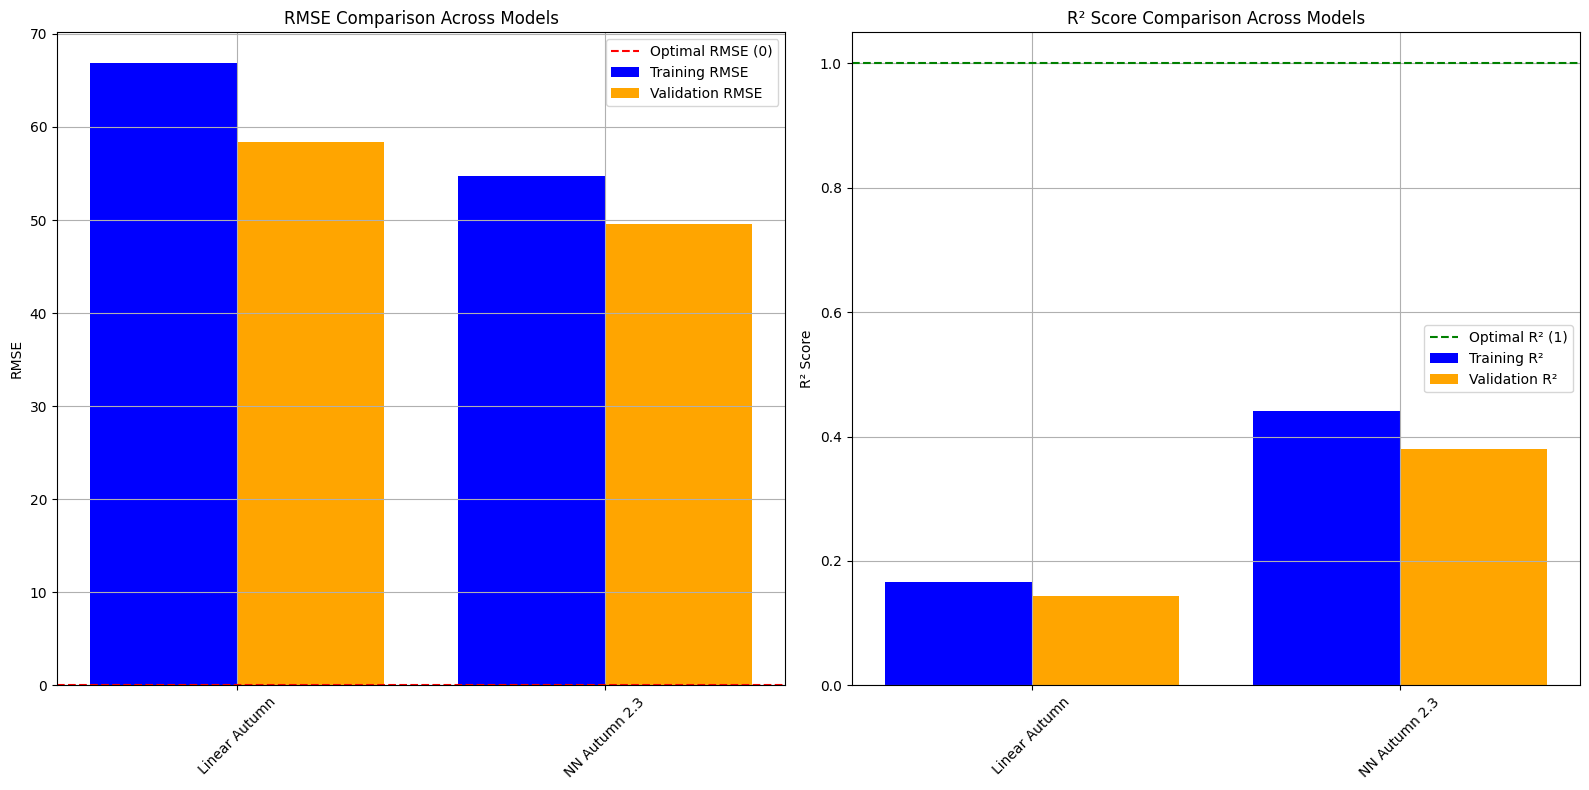

In [30]:
def performanceEvaluation(models, rmse_train, rmse_val, r2_train, r2_val):
    # Plot RMSE Comparison
    plt.figure(figsize=(16, 8))
    
    # RMSE Plot
    plt.subplot(1, 2, 1)
    x = np.arange(len(models))  # Positions for bars
    plt.bar(x - 0.2, rmse_train, width=0.4, label="Training RMSE", color="blue")
    plt.bar(x + 0.2, rmse_val, width=0.4, label="Validation RMSE", color="orange")
    plt.axhline(0, color="red", linestyle="--", label="Optimal RMSE (0)")
    plt.xticks(x, models, rotation=45)
    plt.ylabel("RMSE")
    plt.title("RMSE Comparison Across Models")
    plt.legend()
    plt.grid(True)
    
    # R² Plot
    plt.subplot(1, 2, 2)
    plt.bar(x - 0.2, r2_train, width=0.4, label="Training R²", color="blue")
    plt.bar(x + 0.2, r2_val, width=0.4, label="Validation R²", color="orange")
    plt.axhline(1, color="green", linestyle="--", label="Optimal R² (1)")
    plt.xticks(x, models, rotation=45)
    plt.ylabel("R² Score")
    plt.title("R² Score Comparison Across Models")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
performanceEvaluation(models_spring, rmse_train_spring, rmse_val_spring, r2_train_spring, r2_val_spring)
performanceEvaluation(models_autumn, rmse_train_autumn, rmse_val_autumn, r2_train_autumn, r2_val_autumn)

In [38]:
# Feature Importance Analysis using Linear Regression Coefficients
print("\nSpring Feature Importance:")
importance_spring = pd.DataFrame({'Feature': predictors, 'Importance': lin_reg_spring.coef_})
print(importance_spring.sort_values(by='Importance', ascending=False))

print("\nAutumn Feature Importance:")
importance_autumn = pd.DataFrame({'Feature': predictors, 'Importance': lin_reg_autumn.coef_})
print(importance_autumn.sort_values(by='Importance', ascending=False))


Spring Feature Importance:
      Feature  Importance
7   month_sin   16.232803
0    temp_Oie    9.553921
9     day_sin    0.156809
10    day_cos   -0.327415
5     ppn_DE1   -0.594974
2     ppn_Oie   -1.146584
6      cc_DE1   -1.625046
1       p_Oie   -2.118612
4      wd_Oie   -2.531455
8   month_cos   -2.577850
3      ws_Oie   -4.017082

Autumn Feature Importance:
      Feature  Importance
8   month_cos   14.133601
1       p_Oie    5.510471
6      cc_DE1    2.610069
2     ppn_Oie    0.922753
5     ppn_DE1   -0.196625
10    day_cos   -1.541072
9     day_sin   -1.835884
0    temp_Oie   -2.357275
3      ws_Oie   -3.891112
4      wd_Oie  -10.326018
7   month_sin  -29.152120


In [ ]:
# Feature Importance Analysis for NN 3.0 (based on model 2.3)

# Function to compute gradients for the entire dataset
def compute_dataset_sensitivity(model, X_dataset):
    all_gradients = []
    for sample in X_dataset:  # Iterate over each sample
        with tf.GradientTape() as tape:
            sample = tf.expand_dims(sample, axis=0)  # Add batch dimension
            tape.watch(sample)
            prediction = model(sample)
        gradients = tape.gradient(prediction, sample)
        all_gradients.append(gradients.numpy().flatten())  # Flatten to 1D
    return np.array(all_gradients)
    
# Convert the training data to a TensorFlow tensor
def featureImportance(X_train, model)
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    
    # Calculate sensitivities
    all_sensitivities = compute_dataset_sensitivity(model, X_train_tensor)
    
    # Aggregate sensitivities (mean absolute value for each feature)
    mean_absolute_sensitivity = np.mean(np.abs(all_sensitivities), axis=0)
    
    # Aggregate sensitivities (mean value for each feature)
    mean_sensitivity = np.mean(all_sensitivities, axis=0)
    
    # Extract feature names from the DataFrame for plotting
    feature_names = data[predictors].columns.tolist()
    
    # Plot the average feature sensitivity
    plt.barh(feature_names, mean_absolute_sensitivity)
    plt.title("Average Feature Sensitivity (Training Set)")
    plt.xlabel("Mean Absolute Gradient")
    plt.ylabel("Features")
    plt.show()

In [ ]:
featureImportance(X_train_spring, nn_spring)

In [ ]:
featureImportance(X_train_autumn, nn_autumn)